<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Singapore HDB Resale Price Predictions

--- 
**Primary Learning Objectives:**
1. Creating and iteratively refining a regression model
2. Using [Kaggle](https://www.kaggle.com/) to practice the modeling process
3. Providing business insights through reporting and presentation.

---

## Contents:
- [Background](#Background)
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Feature Engineering](#Feature-Engineering)

## Background
We will create a regression model based on Singapore Housing Dataset. This model will predict the price of a house at sale.

## Data

There are 2 datasets from the [DSI-SG-Project-2 Regression Challenge](https://www.kaggle.com/competitions/dsi-sg-project-2-regression-challenge-hdb-price/overview). These are:
* [`train.csv`](../data/train.csv): Contains all of the training data for the model
* [`test.csv`](../data/test.csv): Contains test data for the model 

## Problem Statement

Can we improve the accuracy of HDB Resale Price predictions for prospective buyers by utilising historical HDB transaction data, to better estimate the market value of the HDB flat they intend to purchase?

## External Research
Based on desktop scans, there are a few factors that influences a HDB flat's [resale price](https://www.iproperty.com.sg/news/4-factors-that-will-affect-your-flats-resale-value/). These are:
- Age and Condition (hdb_age, lease_commence_date): Newer flats and renovated flats/ those in good condition more likely to have higher prices
- Location (town, planning_area): Proximity to the CBD, within close proximity of transit nodes, green spaces, schools, places of worship, malls, etc. more likely to have higher prices
- Size and HDB type (flat_type, flat_model, full_flat_type): Larger flat types more likely to have higher prices 
- Floor level (storey range, mid_storey, lower, upper, mid): Higher floors more likely to fetch higher prices

Therefore, the indicators above will be prioritised for this project.

In addition, this is an article summarising the general steps of used for the regressions tasks: [Building a Machine Learning Pipeline](https://www.linkedin.com/pulse/building-machine-learning-pipeline-siddharth-singh/)

## Data Import and Cleaning

In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import mannwhitneyu
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

import dill

%matplotlib inline

In [2]:
#Read data
housing_df=pd.read_csv("../datasets/train.csv")

/var/folders/qd/bsjdfyz95kd_gl4thk_2jhx80000gn/T/ipykernel_48132/807136295.py:2: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  housing_df=pd.read_csv("../datasets/train.csv")


In [3]:
housing_df.head()

id Tranc_YearMonth             town  flat_type block       street_name  \
0   88471         2016-05  KALLANG/WHAMPOA     4 ROOM    3B  UPP BOON KENG RD   
1  122598         2012-07           BISHAN     5 ROOM   153      BISHAN ST 13   
2  170897         2013-07      BUKIT BATOK  EXECUTIVE  289B    BT BATOK ST 25   
3   86070         2012-04           BISHAN     4 ROOM   232      BISHAN ST 22   
4  153632         2017-12           YISHUN     4 ROOM   876      YISHUN ST 81   

  storey_range  floor_area_sqm  flat_model  lease_commence_date  ...  vacancy  \
0     10 TO 12            90.0     Model A                 2006  ...       78   
1     07 TO 09           130.0    Improved                 1987  ...       45   
2     13 TO 15           144.0   Apartment                 1997  ...       39   
3     01 TO 05           103.0     Model A                 1992  ...       20   
4     01 TO 03            83.0  Simplified                 1987  ...       74   

   pri_sch_affiliation  pri_sch_latitude  pri_sch_longitude  \
0                    1          1.317659         103.882504   
1                    1          1.349783         103.854529   
2                    0          1.345245         103.756265   
3                    1          1.354789         103.844934   
4                    0          1.416280         103.838798   

   sec_sch_nearest_dist                             sec_sch_name  \
0           1138.633422                 Geylang Methodist School   
1            447.894399  Kuo Chuan Presbyterian Secondary School   
2            180.074558             Yusof Ishak Secondary School   
3            389.515528                     Catholic High School   
4            312.025435             Orchid Park Secondary School   

   cutoff_point affiliation sec_sch_latitude  sec_sch_longitude  
0           224           0         1.317659         103.882504  
1           232           0         1.350110         103.854892  
2           188           0         1.342334         103.760013  
3           253           1         1.354789         103.844934  
4           208           0         1.414888         103.838335  

[5 rows x 78 columns]

In [4]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 78 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         150634 non-null  int64  
 1   Tranc_YearMonth            150634 non-null  object 
 2   town                       150634 non-null  object 
 3   flat_type                  150634 non-null  object 
 4   block                      150634 non-null  object 
 5   street_name                150634 non-null  object 
 6   storey_range               150634 non-null  object 
 7   floor_area_sqm             150634 non-null  float64
 8   flat_model                 150634 non-null  object 
 9   lease_commence_date        150634 non-null  int64  
 10  resale_price               150634 non-null  float64
 11  Tranc_Year                 150634 non-null  int64  
 12  Tranc_Month                150634 non-null  int64  
 13  mid_storey                 15

In [5]:
#Set index for ease of manipulation
housing_df.set_index('id', inplace=True)

In [6]:
#Rename columns
housing_df.columns = housing_df.columns.str.lower().str.replace(' ', '_')

## Explore characteristics of dataset variables

In [7]:
housing_df.describe()

floor_area_sqm  lease_commence_date  resale_price     tranc_year  \
count    150634.00000        150634.000000  1.506340e+05  150634.000000   
mean         97.19763          1992.448464  4.491615e+05    2016.489551   
std          24.40304            12.138829  1.433076e+05       2.752396   
min          31.00000          1966.000000  1.500000e+05    2012.000000   
25%          75.00000          1984.000000  3.470000e+05    2014.000000   
50%          95.00000          1992.000000  4.200000e+05    2017.000000   
75%         112.00000          2001.000000  5.200000e+05    2019.000000   
max         280.00000          2019.000000  1.258000e+06    2021.000000   

         tranc_month     mid_storey          lower          upper  \
count  150634.000000  150634.000000  150634.000000  150634.000000   
mean        6.580500       8.284823       7.248370       9.321275   
std         3.345468       5.508074       5.515155       5.507364   
min         1.000000       2.000000       1.000000       3.000000   
25%         4.000000       5.000000       4.000000       6.000000   
50%         7.000000       8.000000       7.000000       9.000000   
75%         9.000000      11.000000      10.000000      12.000000   
max        12.000000      50.000000      49.000000      51.000000   

                 mid  floor_area_sqft  ...  pri_sch_nearest_distance  \
count  150634.000000    150634.000000  ...             150634.000000   
mean        8.284823      1046.235290  ...                395.172974   
std         5.508074       262.674321  ...                234.760931   
min         2.000000       333.684000  ...                 45.668324   
25%         5.000000       807.300000  ...                227.083163   
50%         8.000000      1022.580000  ...                348.876691   
75%        11.000000      1205.568000  ...                502.179385   
max        50.000000      3013.920000  ...               3305.841039   

             vacancy  pri_sch_affiliation  pri_sch_latitude  \
count  150634.000000        150634.000000     150634.000000   
mean       55.368190             0.113195          1.366268   
std        17.903918             0.316832          0.042669   
min        20.000000             0.000000          1.274962   
25%        44.000000             0.000000          1.337289   
50%        54.000000             0.000000          1.364639   
75%        67.000000             0.000000          1.393910   
max       110.000000             1.000000          1.456667   

       pri_sch_longitude  sec_sch_nearest_dist   cutoff_point    affiliation  \
count      150634.000000         150634.000000  150634.000000  150634.000000   
mean          103.839106            508.533220     210.146428       0.031879   
std             0.072637            309.066265      20.010489       0.175677   
min           103.687724             38.913475     188.000000       0.000000   
25%           103.773754            290.285883     188.000000       0.000000   
50%           103.844210            447.377670     208.000000       0.000000   
75%           103.898773            644.284099     224.000000       0.000000   
max           103.962919           3638.977233     260.000000       1.000000   

       sec_sch_latitude  sec_sch_longitude  
count     150634.000000      150634.000000  
mean           1.365986         103.839340  
std            0.042599           0.072630  
min            1.276029         103.687207  
25%            1.337545         103.776008  
50%            1.366132         103.842719  
75%            1.391781         103.899872  
max            1.453280         103.961105  

[8 rows x 57 columns]

#### Observations
- `floor_area_sqm`: No missing values. 
- `lease_commence_date`: No missing values. Not a variable of interest since length of remaining lease is more important based on literature.
- `resale_price`: This is the outcome variable. No missing values. Wide range from \\$15k to \\$1.26m
- `tranc_year`: No missing values. Ranges from 2012 to 2021.
- `tranc_month`:  No missing values. Ranges from Jan to Dec.
- `mid_storey`,`lower`, `upper`, `mid`: No missing values. Likely only one or two will be used since they refer to the min, median, middle and max of the storey_range variable.  Could also look at interactions between `mid` and `upper` as a 10th floor could be mid in one block and top at another.
- `floor_area_sqft`: No missing values. Ranges from 300sqft to 3000sqft.
- `pri_sch_nearest_distance`, ': No missing values. Ranges from 45.7m to 3.3km
- `vacancy`: No missing values. Min vacancy 20? Max 110? To be read tgt with distance of nearest primary school.
- `pri_sch_affiliation`: No missing values.
- `sec_sch_nearest_dist`: No missing values. To be read alongside with `cutoff_point`
- `price_per_sqft` : Should not be using this metric since it's derived from our target. 


In [8]:
# check out the object dtype variables
housing_df.describe(include='object')

tranc_yearmonth         town flat_type   block     street_name  \
count           150634       150634    150634  150634          150634   
unique             110           26         7    2514             553   
top            2018-07  JURONG WEST    4 ROOM       2  YISHUN RING RD   
freq              2088        11451     61136     579            2451   

       storey_range flat_model  full_flat_type              address  \
count        150634     150634          150634               150634   
unique           25         20              43                 9157   
top        04 TO 06    Model A  4 ROOM Model A  91, TANGLIN HALT RD   
freq          34699      46261           35127                  106   

       residential commercial market_hawker multistorey_carpark  \
count       150634     150634        150634              150634   
unique           1          2             2                   2   
top              Y          N             N                   N   
freq        150634     121815        150619              150592   

       precinct_pavilion  postal planning_area mrt_name bus_stop_name  \
count             150634  150634        150634   150634        150634   
unique                 2   17483            32       94          1657   
top                    N  142091   Jurong West  Punggol       Blk 121   
freq              150499      80         11451     7671           774   

                    pri_sch_name                sec_sch_name  
count                     150634                      150634  
unique                       177                         134  
top     Marsiling Primary School  Bendemeer Secondary School  
freq                        2075                        3384

#### Observations:
- `tranc_yearmonth`: To disregard and use separate year month variables to capture time effects
- `town`: 26 towns. Likely to use this variable or planning area or both
- `flat_type`, `flat_model`, `full_flat_type`: Ok, will use one of them after examining
- `block`, `street_name`, `address`: Good-to-haves, but can exclude
- `storey_range`: Root variable for numeric variables about the storey range. Likely to use numeric variables given that 25 dummy variables will be created with higher risk of overfitting.
- `residential`: Not helpful. No variation will not use.
- `commerical`: Indication of co-location, which may explain why 0 distance to mall for some units
- `market_hawker`: Indication of co-location with hawker centre or market. Likely to have duplicates if distance variables are used
- `multistorey_carpark`, `precinct_pavilion`: Useful to include but may need to regularise to prevent overfitting. 
- `postal`: Useful for imputing missing values if needed. 
- `planning_area`: Similar to town variable. There are more planning areas than towns, more variation likely better predictive power
- `mrt_name`, `bus_stop_name`: Not helpful. Will not use.
- `pri_sch_name`/`sec_sch_name`: There may be potential impact if famous schools. Consider with cut-off points?

## Correlation of Variables

In [9]:
# Construct correlation matrix to understand which features are most strongly
housing_df_corr = housing_df.corr()

/var/folders/qd/bsjdfyz95kd_gl4thk_2jhx80000gn/T/ipykernel_48132/3131778940.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  housing_df_corr = housing_df.corr()


In [10]:
sorted_housing_df_corr = housing_df_corr.abs().sort_values(by='resale_price', ascending=False)
sorted_housing_df_corr

floor_area_sqm  lease_commence_date  resale_price  \
resale_price                     0.654120             0.350337      1.000000   
floor_area_sqm                   1.000000             0.283182      0.654120   
floor_area_sqft                  1.000000             0.283182      0.654120   
price_per_sqft                   0.183124             0.174912      0.606288   
max_floor_lvl                    0.073098             0.458348      0.495650   
3room_sold                       0.585996             0.496150      0.410368   
5room_sold                       0.391143             0.332575      0.359434   
year_completed                   0.288671             0.988912      0.353698   
upper                            0.023832             0.263584      0.353552   
mid                              0.023855             0.265112      0.353213   
mid_storey                       0.023855             0.265112      0.353213   
lower                            0.023851             0.266333      0.352466   
lease_commence_date              0.283182             1.000000      0.350337   
hdb_age                          0.283182             1.000000      0.350337   
exec_sold                        0.512606             0.044453      0.337500   
sec_sch_latitude                 0.213272             0.356244      0.216303   
latitude                         0.214800             0.360358      0.216153   
bus_stop_latitude                0.214928             0.360586      0.215760   
mrt_latitude                     0.208544             0.356519      0.214939   
pri_sch_latitude                 0.217131             0.366473      0.214707   
hawker_within_2km                0.299120             0.295798      0.185607   
2room_sold                       0.241249             0.047014      0.145287   
total_dwelling_units             0.434511             0.154468      0.140725   
hawker_within_1km                0.279990             0.224593      0.134415   
mrt_nearest_distance             0.053186             0.154657      0.128222   
mall_within_2km                  0.061550             0.012383      0.115703   
sec_sch_longitude                0.009090             0.006985      0.108911   
pri_sch_longitude                0.009764             0.009005      0.106681   
longitude                        0.012033             0.007462      0.106596   
mrt_longitude                    0.013885             0.007962      0.106506   
bus_stop_longitude               0.012127             0.007886      0.106394   
sec_sch_nearest_dist             0.063315             0.070921      0.095339   
4room_sold                       0.067950             0.285400      0.092600   
mall_nearest_distance            0.106064             0.264398      0.087096   
mall_within_500m                 0.052396             0.221587      0.086955   
3room_rental                     0.110405             0.108907      0.079965   
2room_rental                     0.112918             0.074427      0.077548   
mall_within_1km                  0.002157             0.058893      0.069929   
mrt_interchange                  0.075549             0.265905      0.066413   
hawker_within_500m               0.165406             0.098590      0.062637   
studio_apartment_sold            0.050890             0.140585      0.040312   
1room_sold                       0.063309             0.033546      0.039434   
1room_rental                     0.058999             0.001397      0.037993   
multigen_sold                    0.043909             0.009338      0.037406   
cutoff_point                     0.077721             0.060264      0.034572   
hawker_food_stalls               0.061116             0.133437      0.033581   
bus_stop_nearest_distance        0.006461             0.034772      0.031940   
pri_sch_affiliation              0.042265             0.119898      0.030931   
tranc_year                       0.021400             0.204991      0.019146   
vacancy                    

Observations:
- Size of the HDB (e.g. floor area, flat type (e.g. no. of rooms), followed by condition (e.g. year completed, age..), other flat characteristics (e.g. upper, lower, mid..) had the highest correlation with resale price. 
- Within each set (e.g. floor area sqm; floor area sqft), the features had very similar coefficients. This suggests that we could streamline the number of features under each set to avoid overfitting in the model. 

## Examine Multicollinearity
- To improve model, we aim to remove variables that are collinear and only leave one of those variables in each set.
- Note: Greater the value of R-squared, greater is the VIF. Hence, greater VIF denotes greater correlation.

#### Examining `hdb_age`, `lease_commence_date`

In [11]:
X_variables = housing_df[['hdb_age', 'lease_commence_date']]

In [12]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]
vif_data["VIF"] 

0    6.349301
1    6.349301
Name: VIF, dtype: float64

Observation: 
- vif > 5, therefore, can consider keeping only one of the 2 variables. Choose `hdb_age`.

#### Examining `flat_type`, `flat_model` and `full_flat_type`

In [13]:
Y_variables = pd.get_dummies(housing_df[['flat_type', 'flat_model','full_flat_type']])

In [14]:
vif_data = pd.DataFrame()
vif_data["feature"] = Y_variables.columns
vif_data["VIF"] = [variance_inflation_factor(Y_variables.values, i) for i in range(len(Y_variables.columns))]
vif_data["VIF"] 

/Users/sytan/opt/anaconda3/envs/newenv/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


0              inf
1              inf
2     1.407753e+03
3     3.210647e+02
4     1.567026e+02
          ...     
65    1.416234e+07
66    2.184584e+05
67             inf
68             inf
69    9.007199e+15
Name: VIF, Length: 70, dtype: float64

Observation:
- vif > 5 for all. Therefore, can consider keeping only one of the 3 variables. Choose `full_flat_type` for more complete coverage.

#### Examining `storey_range`, `mid_storey`, `lower`, `upper`, `mid`

In [15]:
Z_variables = pd.get_dummies(housing_df[['storey_range', 'mid_storey','lower', 'upper', 'mid']])

In [16]:
vif_data = pd.DataFrame()
vif_data["feature"] = Z_variables.columns
vif_data["VIF"] = [variance_inflation_factor(Z_variables.values, i) for i in range(len(Z_variables.columns))]
vif_data["VIF"] 

/Users/sytan/opt/anaconda3/envs/newenv/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


0     inf
1     inf
2     inf
3     inf
4     inf
5     inf
6     inf
7     inf
8     inf
9     inf
10    inf
11    inf
12    inf
13    inf
14    inf
15    inf
16    inf
17    inf
18    inf
19    inf
20    inf
21    inf
22    inf
23    inf
24    inf
25    inf
26    inf
27    inf
28    inf
Name: VIF, dtype: float64

Observation:
- vif is inf for all. Therefore, can consider keeping only one of the 5 variables. For easier interpretation, choose `mid` for a numeric variable and middle of each storey range.

#### Examining `planning_area` and `town`

In [17]:
AA_variables = pd.get_dummies(housing_df[['planning_area', 'town']])

In [18]:
vif_data = pd.DataFrame()
vif_data["feature"] = AA_variables.columns
vif_data["VIF"] = [variance_inflation_factor(AA_variables.values, i) for i in range(len(AA_variables.columns))]
vif_data["VIF"] 

/Users/sytan/opt/anaconda3/envs/newenv/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


0     3.464307e+13
1     1.421474e+10
2     4.005331e+08
3     9.275761e+05
4     2.059777e+04
5     3.774937e+06
6              inf
7              inf
8     3.169825e+04
9              inf
10             inf
11    3.085102e+03
12    1.888780e+04
13             inf
14    4.767426e+04
15    1.671750e+09
16             inf
17    8.559306e+04
18             inf
19             inf
20             inf
21             inf
22             inf
23    2.791061e+10
24    7.450278e+09
25    1.125900e+15
26    8.102880e+05
27             inf
28    1.841089e+07
29             inf
30    3.328634e+04
31    8.813220e+10
32    1.643248e+10
33             inf
34    1.390441e+05
35    2.190528e+04
36    4.404514e+08
37    3.550660e+04
38             inf
39             inf
40    2.689154e+06
41             inf
42    1.950638e+05
43    1.482502e+07
44             inf
45    1.599638e+06
46             inf
47             inf
48             inf
49             inf
50             inf
51    2.524991e+04
52    2.5838

Observation:

- vif > 5 for all. Therefore, can consider keeping only one of the 2 variables. Choose `planning_area` since more variation in the data.

## Examining Missing Values

`mall_nearest_distance` and `mall_within_500m/ 1km/ 2km`

In [19]:
# Check what proportion of variable is null
housing_df['mall_nearest_distance'].isnull().mean()

0.005503405605640161

In [20]:
# check whether all mall related variables are null when the mall_nearest_distance variable is null
housing_df.loc[housing_df['mall_nearest_distance'].isnull(), 
               ['mall_within_500m', 'mall_within_1km', 'mall_within_2km']].sum()

mall_within_500m    0.0
mall_within_1km     0.0
mall_within_2km     0.0
dtype: float64

Observations:
- 0.5% are null and all other mall variables are null for these datapoints. Can consider dropping since less than benchmark of 5%.
- To consider using the longitude and latitude of each HDB to impute the distance to the nearest mall to avoid losing data
- Thereafter, we will fill the mall_within_500m/1km/2km variables based on the imputed distance.

In [21]:
#Check for malls within 2km but mall_within_2km is null
housing_df.loc[(housing_df['mall_nearest_distance'] > 2000.0) & (housing_df['mall_within_2km'].isnull()), 
               ['mall_within_500m', 'mall_within_1km', 'mall_within_2km']].agg(['count', 'sum'])

mall_within_500m  mall_within_1km  mall_within_2km
count               0.0              0.0              0.0
sum                 0.0              0.0              0.0

In [22]:
# Check for malls within 1km but mall_within_1km is null
housing_df.loc[(housing_df['mall_nearest_distance'] > 1000.0) & (housing_df['mall_within_1km'].isnull()), 
               ['mall_within_500m', 'mall_within_1km', 'mall_within_2km']].agg(['count', 'sum'])

mall_within_500m  mall_within_1km  mall_within_2km
count               0.0              0.0          23486.0
sum                 0.0              0.0         108573.0

In [23]:
# Check for malls within 500mm but mall_within_500m is null
housing_df.loc[(housing_df['mall_nearest_distance'] > 500.0) & (housing_df['mall_within_500m'].isnull()), 
               ['mall_within_500m', 'mall_within_1km', 'mall_within_2km']].agg(['count', 'sum'])

mall_within_500m  mall_within_1km  mall_within_2km
count               0.0          67363.0          90849.0
sum                 0.0         123130.0         442473.0

Observations:
- The results suggest that the missing values in the mall_within_500m/1km/2km represent 0, except for the datapoints with missing values for mall_nearest_distance.
- Therefore, we will impute all missing values to 0 after imputing the missing mall_nearest_distance.

`hawker_within_500m/1km/2km`

In [24]:
#Check for hawker within 2km but hawker_within_2km is null
housing_df.loc[(housing_df['hawker_nearest_distance'] > 2000.0) & (housing_df['hawker_within_2km'].isnull()), 
               ['hawker_within_500m', 'hawker_within_1km', 'hawker_within_2km']].agg(['count', 'sum'])

hawker_within_500m  hawker_within_1km  hawker_within_2km
count                 0.0                0.0                0.0
sum                   0.0                0.0                0.0

In [25]:
# Check for hawker within 1km but hawker_within_1km is null
housing_df.loc[(housing_df['hawker_nearest_distance'] > 1000.0) & (housing_df['hawker_within_1km'].isnull()), 
               ['hawker_within_500m', 'hawker_within_1km', 'hawker_within_2km']].agg(['count', 'sum'])

hawker_within_500m  hawker_within_1km  hawker_within_2km
count                 0.0                0.0            31666.0
sum                   0.0                0.0            59909.0

In [26]:
# Check for hawker within 500m but hawker_within_500m is null
housing_df.loc[(housing_df['hawker_nearest_distance'] > 500.0) & (housing_df['hawker_within_500m'].isnull()), 
               ['hawker_within_500m', 'hawker_within_1km', 'hawker_within_2km']].agg(['count', 'sum'])

hawker_within_500m  hawker_within_1km  hawker_within_2km
count                 0.0            36522.0            68188.0
sum                   0.0            51378.0           197722.0

Oberservation:

- This suggests that the missing values in the hawker_within_500m/1km/2km represent 0
- Will impute all missing values to 0

In [27]:
# Fill all hawker missing values with 0
housing_df['hawker_within_500m'].fillna(0, inplace=True)
housing_df['hawker_within_1km'].fillna(0, inplace=True)
housing_df['hawker_within_2km'].fillna(0, inplace=True)

## Examining Outliers

<AxesSubplot: >

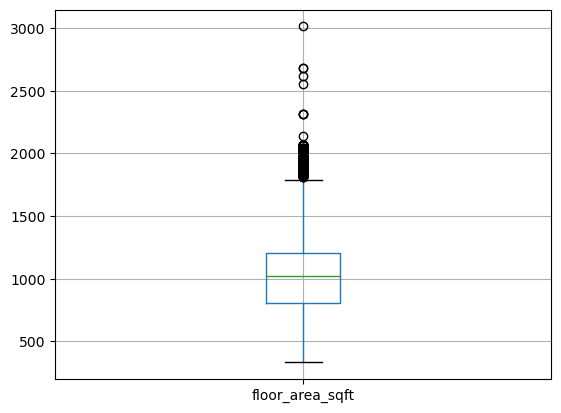

In [28]:
# check for floor_area_sqft
housing_df.boxplot('floor_area_sqft')

In [29]:
# Exploring the outliers
housing_df[housing_df['floor_area_sqft'] > 2000]

tranc_yearmonth             town  flat_type block      street_name  \
id                                                                          
67125          2015-09        WOODLANDS  EXECUTIVE   808  WOODLANDS ST 81   
28091          2015-03  KALLANG/WHAMPOA     3 ROOM    53       JLN MA'MOR   
146002         2021-03           BISHAN  EXECUTIVE   446   BRIGHT HILL DR   
62268          2013-04        WOODLANDS  EXECUTIVE   308  WOODLANDS AVE 1   
67140          2012-06        WOODLANDS  EXECUTIVE   808  WOODLANDS ST 81   
...                ...              ...        ...   ...              ...   
183267         2017-09        WOODLANDS  EXECUTIVE   307  WOODLANDS AVE 1   
67038          2020-09        WOODLANDS  EXECUTIVE   807  WOODLANDS ST 81   
65688          2017-03        WOODLANDS  EXECUTIVE   834  WOODLANDS ST 83   
66787          2018-02        WOODLANDS  EXECUTIVE   832  WOODLANDS ST 83   
57260          2020-10        WOODLANDS  EXECUTIVE   830  WOODLANDS ST 83   

       storey_range  floor_area_sqm  flat_model  lease_commence_date  \
id                                                                     
67125      10 TO 12           189.0   Apartment                 1994   
28091      01 TO 03           280.0     Terrace                 1972   
146002     07 TO 09           243.0  Maisonette                 1990   
62268      07 TO 09           189.0   Apartment                 1994   
67140      01 TO 03           189.0   Apartment                 1994   
...             ...             ...         ...                  ...   
183267     07 TO 09           192.0   Apartment                 1994   
67038      01 TO 03           192.0   Apartment                 1994   
65688      07 TO 09           189.0   Apartment                 1994   
66787      04 TO 06           189.0   Apartment                 1994   
57260      04 TO 06           192.0   Apartment                 1994   

        resale_price  ...  vacancy  pri_sch_affiliation  pri_sch_latitude  \
id                    ...                                                   
67125       798000.0  ...       48                    0          1.442036   
28091      1060000.0  ...       48                    0          1.321689   
146002     1092888.0  ...       30                    0          1.360736   
62268       780000.0  ...       72                    0          1.430640   
67140       690000.0  ...       48                    0          1.442036   
...              ...  ...      ...                  ...               ...   
183267      750000.0  ...       72                    0          1.430640   
67038       750000.0  ...       48                    0          1.442036   
65688       800000.0  ...       48                    0          1.442036   
66787       720000.0  ...       39                    0          1.436746   
57260       760000.0  ...       39                    0          1.436746   

        pri_sch_longitude  sec_sch_nearest_dist                sec_sch_name  \
id                                                                            
67125          103.788340            205.057334  Riverside Secondary School   
28091          103.857652            678.037848  Bendemeer Secondary School   
146002         103.833076            956.557404     Peirce Secondary School   
62268          103.778175            131.807986     Fuchun Secondary School   
67140          103.788340            205.057334  Riverside Secondary School   
...                   ...                   ...                         ...   
183267         103.778175            177.036243     Fuchun Secondary School   
67038          103.788340            158.490026  Riverside Secondary School   
65688          103.788340            325.488455  Evergreen Secondary School   
66787          103.791772            313.975367  Riverside Secondary School   
57260          103.791772            339.458733  Riverside Secondary School   

       cutoff_point affiliation  sec_s

Observations:
- Just the executive and multi-gen units which we should retain. 

<AxesSubplot: >

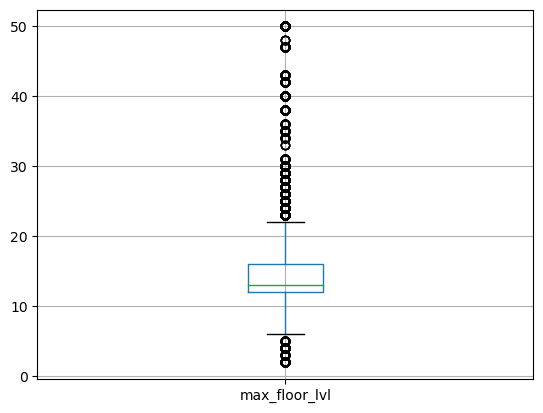

In [30]:
# check for max_floor_lvl
housing_df.boxplot('max_floor_lvl')

Observation:
- Either very low rise (e.g. 1st gen terrace hdb) or very high rise HDBs (e.g. newer HDBs). Looks ok to keep.

<AxesSubplot: >

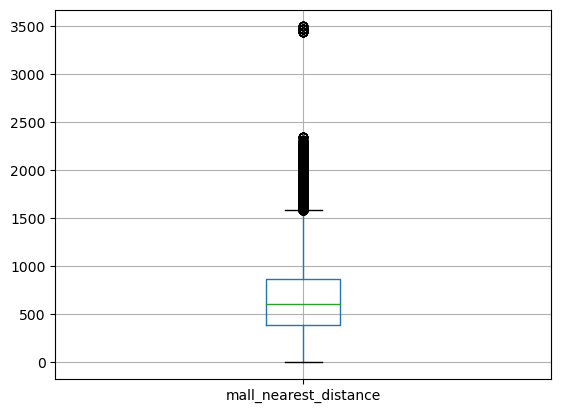

In [31]:
# check for mall_nearest_distance
housing_df.boxplot('mall_nearest_distance')

Observations:
- Nothing surprising, other than the few that is 3.5km away from mall. To keep all

<AxesSubplot: >

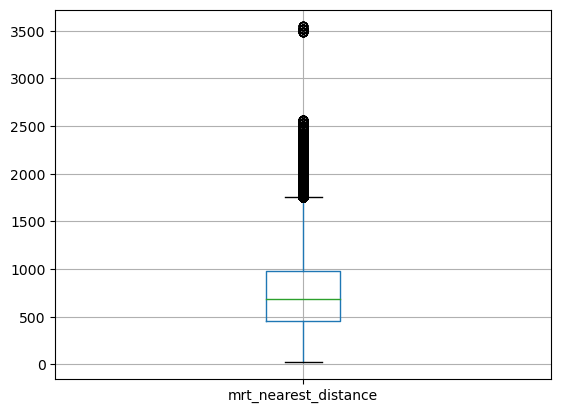

In [32]:
# check for mrt_nearest_distance
housing_df.boxplot('mrt_nearest_distance')

Observations:
- To explore those that are 3.5.km away abit further 

In [33]:
# Exploring the outlier
housing_df[housing_df['mrt_nearest_distance'] > 3000]

tranc_yearmonth       town flat_type block        street_name  \
id                                                                    
13221         2019-12  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
13215         2017-09  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
48233         2017-06  PASIR RIS    3 ROOM     1  CHANGI VILLAGE RD   
13217         2018-02  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
13211         2016-09  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
13208         2015-05  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
13225         2021-03  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
48243         2014-03  PASIR RIS    3 ROOM     1  CHANGI VILLAGE RD   
21172         2015-02  PASIR RIS    3 ROOM     4  CHANGI VILLAGE RD   
13235         2014-08  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
13210         2016-08  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
13213         2017-07  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
13212         2017-01  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
48237         2019-08  PASIR RIS    3 ROOM     1  CHANGI VILLAGE RD   
13216         2018-01  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
48241         2012-12  PASIR RIS    3 ROOM     1  CHANGI VILLAGE RD   
21179         2014-02  PASIR RIS    3 ROOM     4  CHANGI VILLAGE RD   
48242         2013-01  PASIR RIS    3 ROOM     1  CHANGI VILLAGE RD   
48240         2012-07  PASIR RIS    3 ROOM     1  CHANGI VILLAGE RD   
48239         2020-11  PASIR RIS    3 ROOM     1  CHANGI VILLAGE RD   
21178         2013-12  PASIR RIS    3 ROOM     4  CHANGI VILLAGE RD   
13233         2013-11  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
13231         2013-05  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
13227         2012-03  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
13228         2012-06  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
13223         2020-07  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
21174         2019-08  PASIR RIS    3 ROOM     4  CHANGI VILLAGE RD   
21175         2020-11  PASIR RIS    3 ROOM     4  CHANGI VILLAGE RD   
13207         2015-04  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
13214         2017-08  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
48234         2018-07  PASIR RIS    3 ROOM     1  CHANGI VILLAGE RD   
13206         2015-01  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
13224         2021-03  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
13229         2012-10  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
13236         2014-11  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
13222         2020-03  PASIR RIS    3 ROOM     5  CHANGI VILLAGE RD   
48238         2019-10  PASIR RIS    3 ROOM     1  CHANGI VILLAGE RD   
21173         2017-04  PASIR RIS    3 ROOM     4  CHANGI VILLAGE RD   

      storey_range  floor_area_sqm flat_model  lease_commence_date  \
id                                                                   
13221     04 TO 06            66.0   Improved                 1981   
13215     04 TO 06            66.0   Improved                 1981   
48233     01 TO 03            77.0   Improved                 1980   
13217     04 TO 06            74.0   Improved                 1981   
13211     01 TO 03            66.0   Improved                 1981   
13208     04 TO 06            66.0   Improved                 1981   
13225     01 TO 03            66.0   Improved                 1981   
48243     01 TO 03            67.0   Improved                 1980   
21172     04 TO 06            66.0   Improved                 1980   
13235     01 TO 03            66.0   Improved                 1981   
13210     04 TO 06            66.0   Improved                 1981   
13213     01 TO 03            66.0   Improved                 1981   
13212     04 TO 06            66.0   Improved                 1981   
48237     01 TO 03            67.0   Improved                 1980   
13216     04 TO 06            66.0   Improved

Observations:
- The outliers belong to the Changi Village. Given that there are no MRT stations in the vicinity the result is unsurprising. To keep all.

## Export Clean Data

In [34]:
# Export clean data
housing_df.to_csv('../datasets/train_cleaned.csv')

## Import Data

In [35]:
# Read in clean dataset
housing_df = pd.read_csv('../datasets/train_cleaned.csv')

/var/folders/qd/bsjdfyz95kd_gl4thk_2jhx80000gn/T/ipykernel_48132/3298899192.py:2: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  housing_df = pd.read_csv('../datasets/train_cleaned.csv')


## Exploratory Data Analysis

#### Location-based Variables
To look at correlation with outcome variable

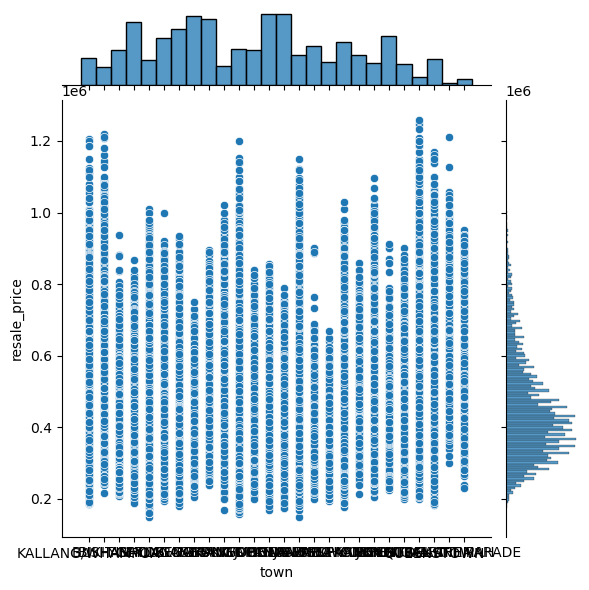

In [36]:
# check jointplot for town variable
sns.jointplot(data=housing_df, x='town', y='resale_price')

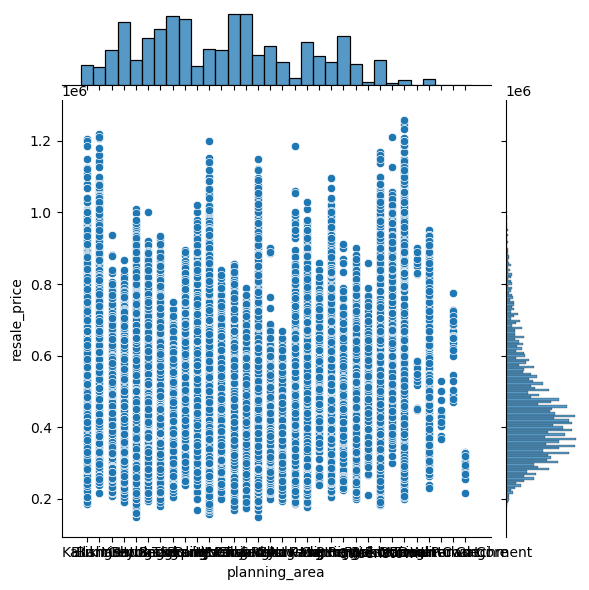

In [37]:
# check jointplot for planning_area variable
sns.jointplot(data=housing_df, x='planning_area', y='resale_price')

In [38]:
housing_df['planning_area'].value_counts(normalize=True)

Jurong West                0.076019
Woodlands                  0.075242
Sengkang                   0.073483
Tampines                   0.069745
Yishun                     0.066665
Bedok                      0.060159
Punggol                    0.051735
Hougang                    0.050168
Ang Mo Kio                 0.045860
Choa Chu Kang              0.042009
Bukit Merah                0.038862
Bukit Batok                0.037840
Bukit Panjang              0.037747
Toa Payoh                  0.031978
Pasir Ris                  0.031367
Queenstown                 0.027238
Geylang                    0.026461
Sembawang                  0.024716
Clementi                   0.024118
Jurong East                0.023036
Kallang                    0.020998
Serangoon                  0.020719
Bishan                     0.019059
Novena                     0.007243
Marine Parade              0.006260
Outram                     0.005039
Rochor                     0.003107
Bukit Timah                0

Observations:

- As aforementioned under the Multicollinearity section, only 1 out of the 2 variables should be used.
- `planning_area` shows more distinct distributions compared to `town` where many variables appear to have the similar ranges of prices. Therefore, more inclined to use `planning_area`.

#### Condition-based Variables
To look at correlation with outcome variable

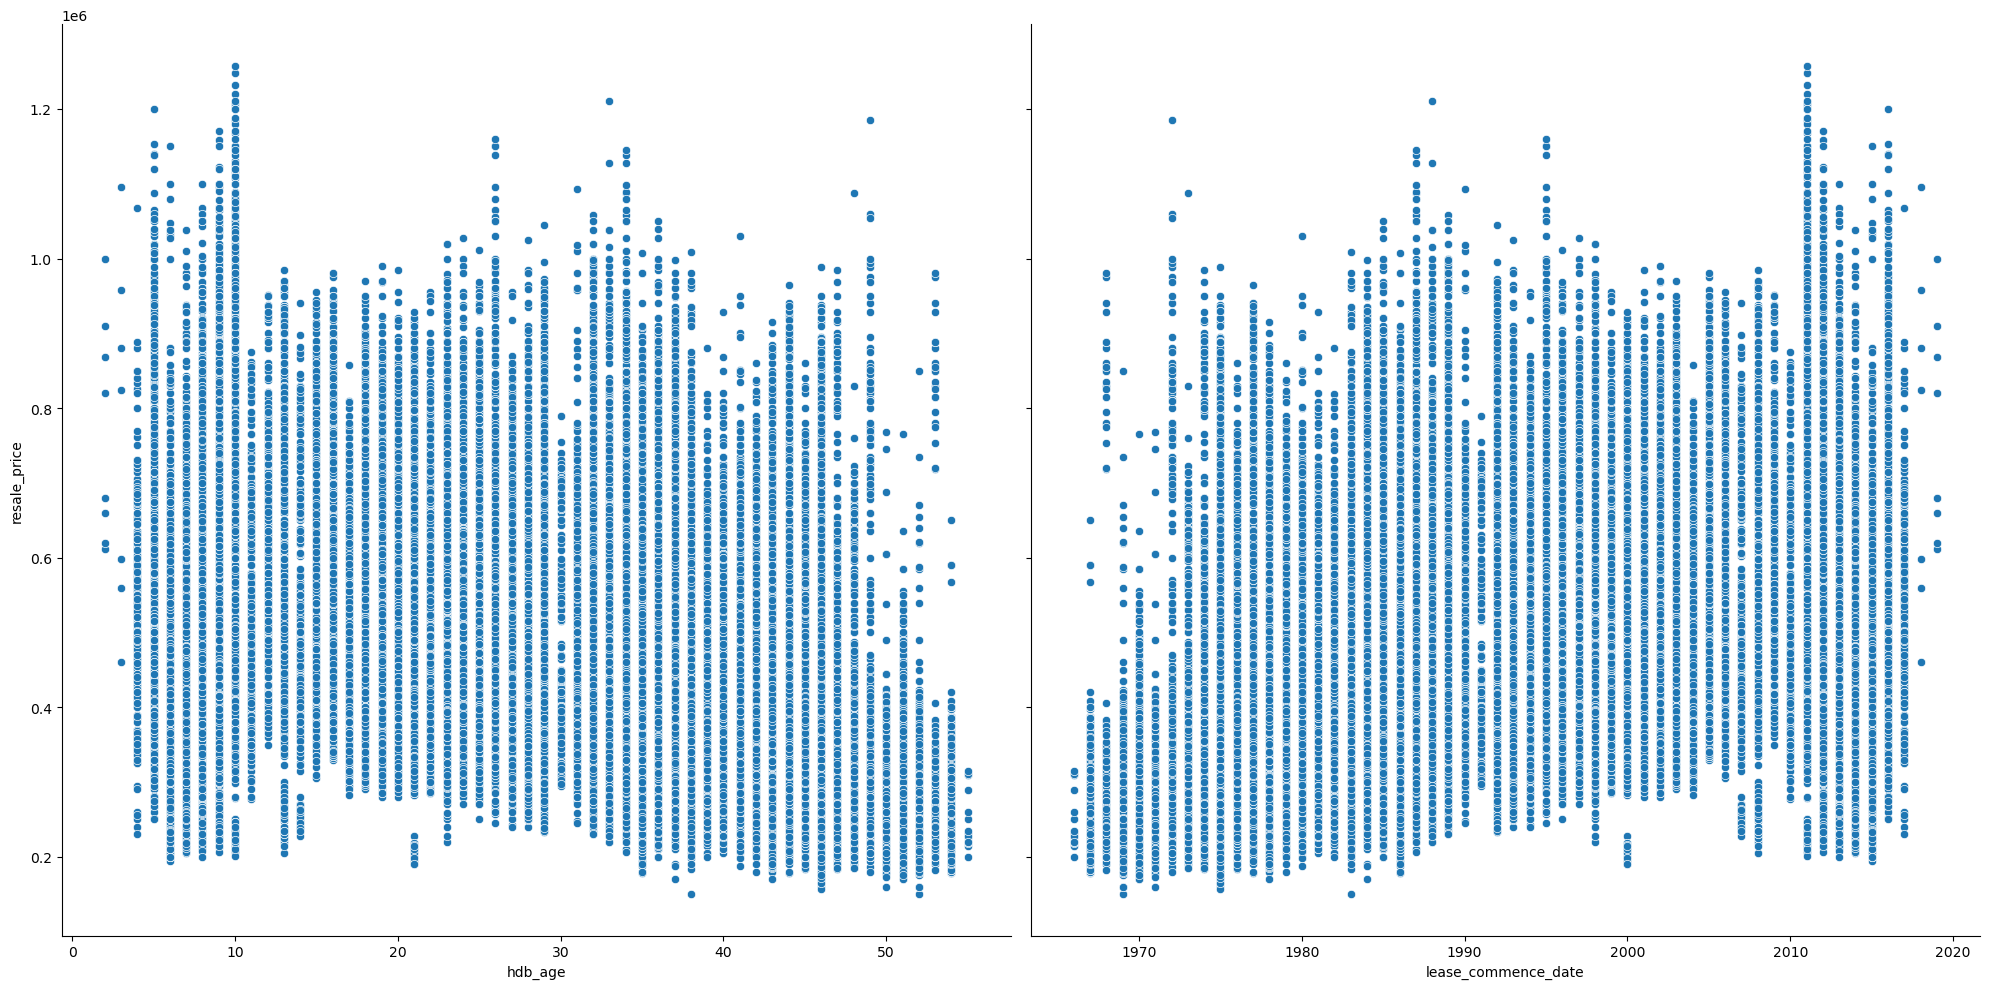

In [39]:
# check out pairplot of both variables
sns.pairplot(data=housing_df, y_vars='resale_price', x_vars=['hdb_age','lease_commence_date'],height=10)
plt.tight_layout()

Observations:

- As aforementioned in the Multicollinearity section, only 1 of the variables should be used
- Expectedly, the results are mirror image of one another. Hence, using one will suffice, will use `hdb_age`.
- Range of resale prices seem to drop as HDBs gets older.
- Interestingly, some outliers on the high end especially on the oldest HDBs. These could be the first HDBs/ HDB terraces which are very limited in supply. Could try teasing out from the flat model/type, given that such HDBs tend to have unique flat types.

#### Housing Size and HDB-Type Variables
To look at correlation with outcome variable

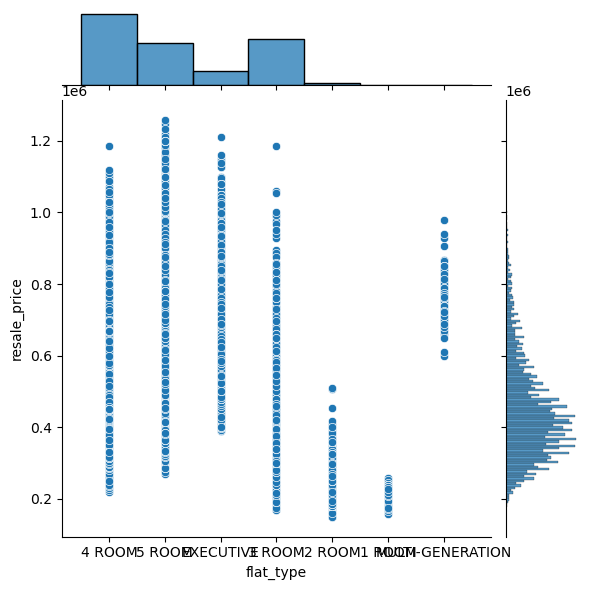

In [40]:
# check jointplot for flat_type variable
sns.jointplot(data=housing_df, x='flat_type', y='resale_price')

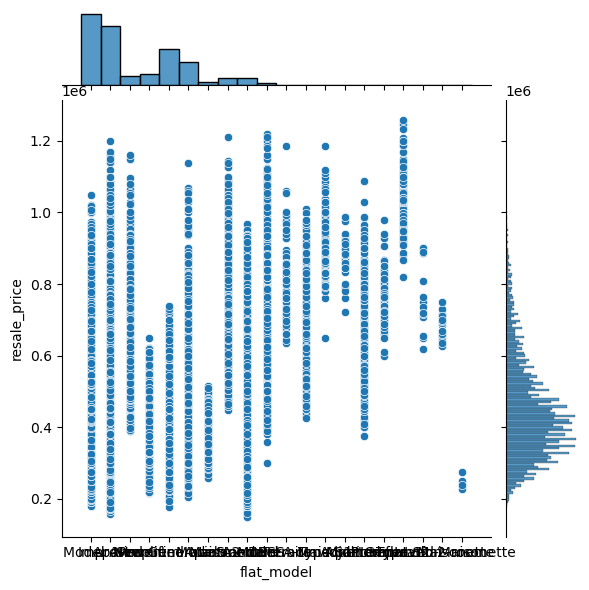

In [41]:
# check jointplot for flat_model variable
sns.jointplot(data=housing_df, x='flat_model', y='resale_price')

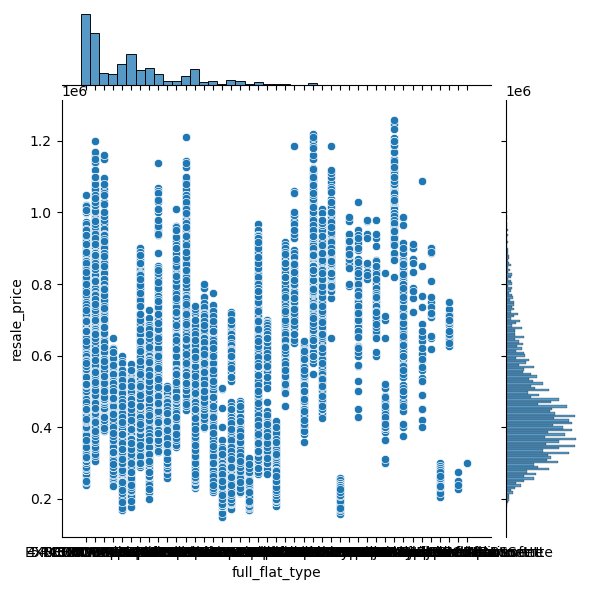

In [42]:
# check jointplot for full_flat_type variable
sns.jointplot(data=housing_df, x='full_flat_type', y='resale_price')

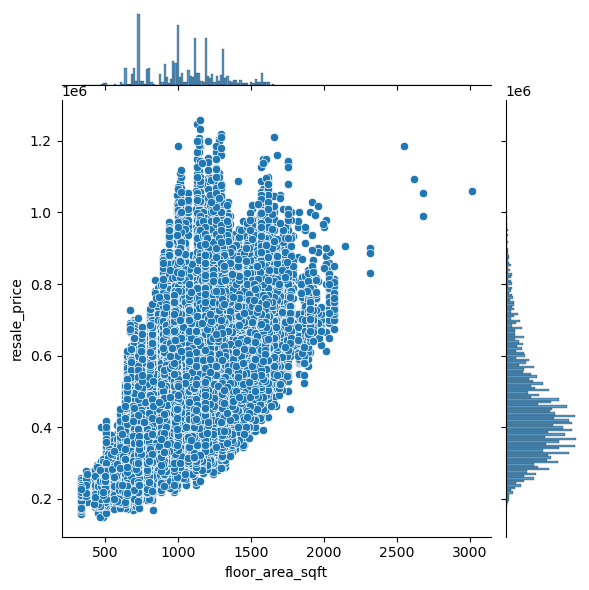

In [43]:
# check jointplot for floor_area_sqft variable
sns.jointplot(data=housing_df, x='floor_area_sqft', y='resale_price')

In [44]:
len(housing_df['flat_type'].unique())

7

In [45]:
len(housing_df['flat_model'].unique())

20

In [46]:
len(housing_df['full_flat_type'].unique())

43

Observations:
- As aforementioned in the Multicollinearity section, only 1 or 2 of the categorical variables should be used
- `full_flat_type` In respect to OHE, notwithstanding that full flat type has the most variables (i.e. 43), it is the most effective/comprehensive due to both flat model and flat type in the attribute. Will use this.
- `floor_area_sqft` has strong corelation with the outcome variable. To include.

In [47]:
#### Floor Level

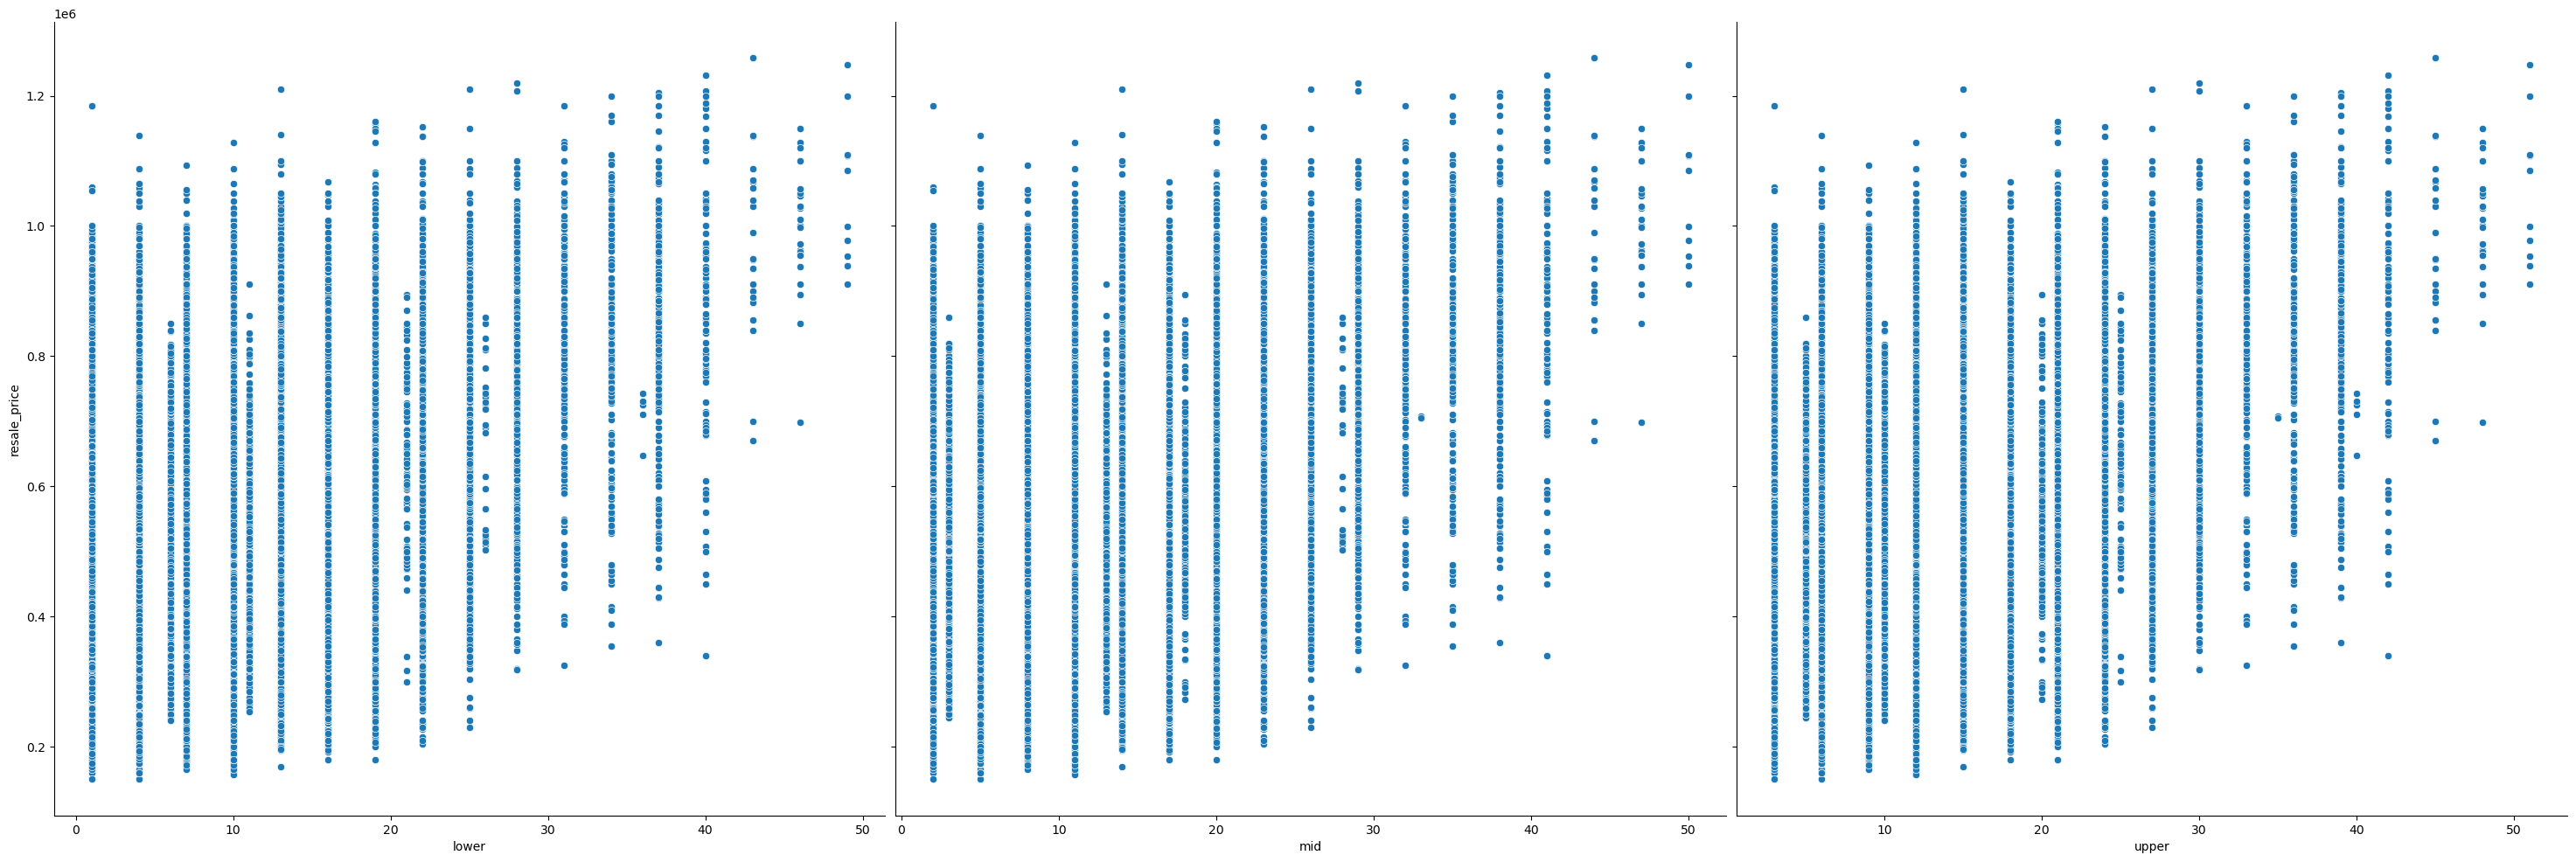

In [48]:
# check pairplot for 'lower', 'mid', 'upper'
sns.pairplot(housing_df, x_vars=['lower', 'mid', 'upper'], y_vars='resale_price', height=10)

Observations:
- Mirror image across all 3 variables.

#### Seasonality
To explore whether different years and months of transaction may have an effect on resale price.

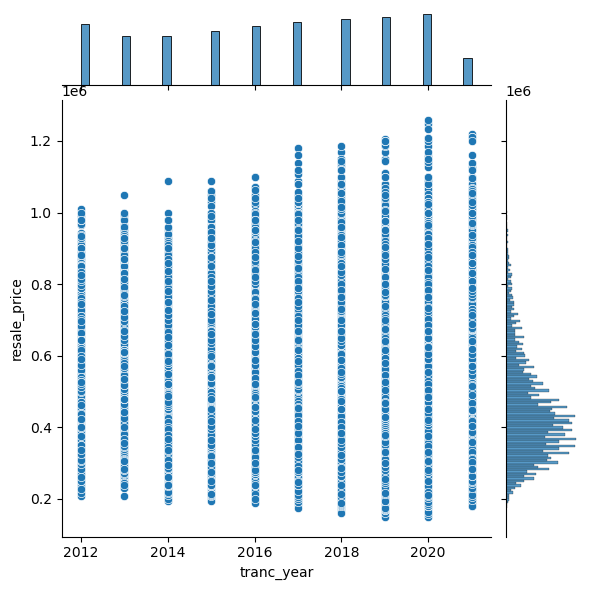

In [49]:
sns.jointplot(data=housing_df, x='tranc_year', y='resale_price')

Observations:
- Slight upward trend with some years being better (e.g. 2020 good year)
- To include `tranc_year` as a time control

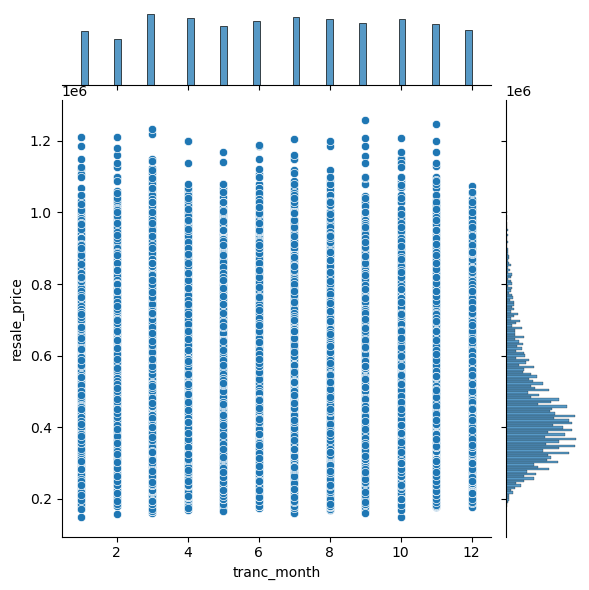

In [50]:
sns.jointplot(data=housing_df, x='tranc_month', y='resale_price')

Observations:
- Some months are better (e..g Sep and Nov)
- To include `tranc_month` as time control

#### Presence of amenities

Mall amenity

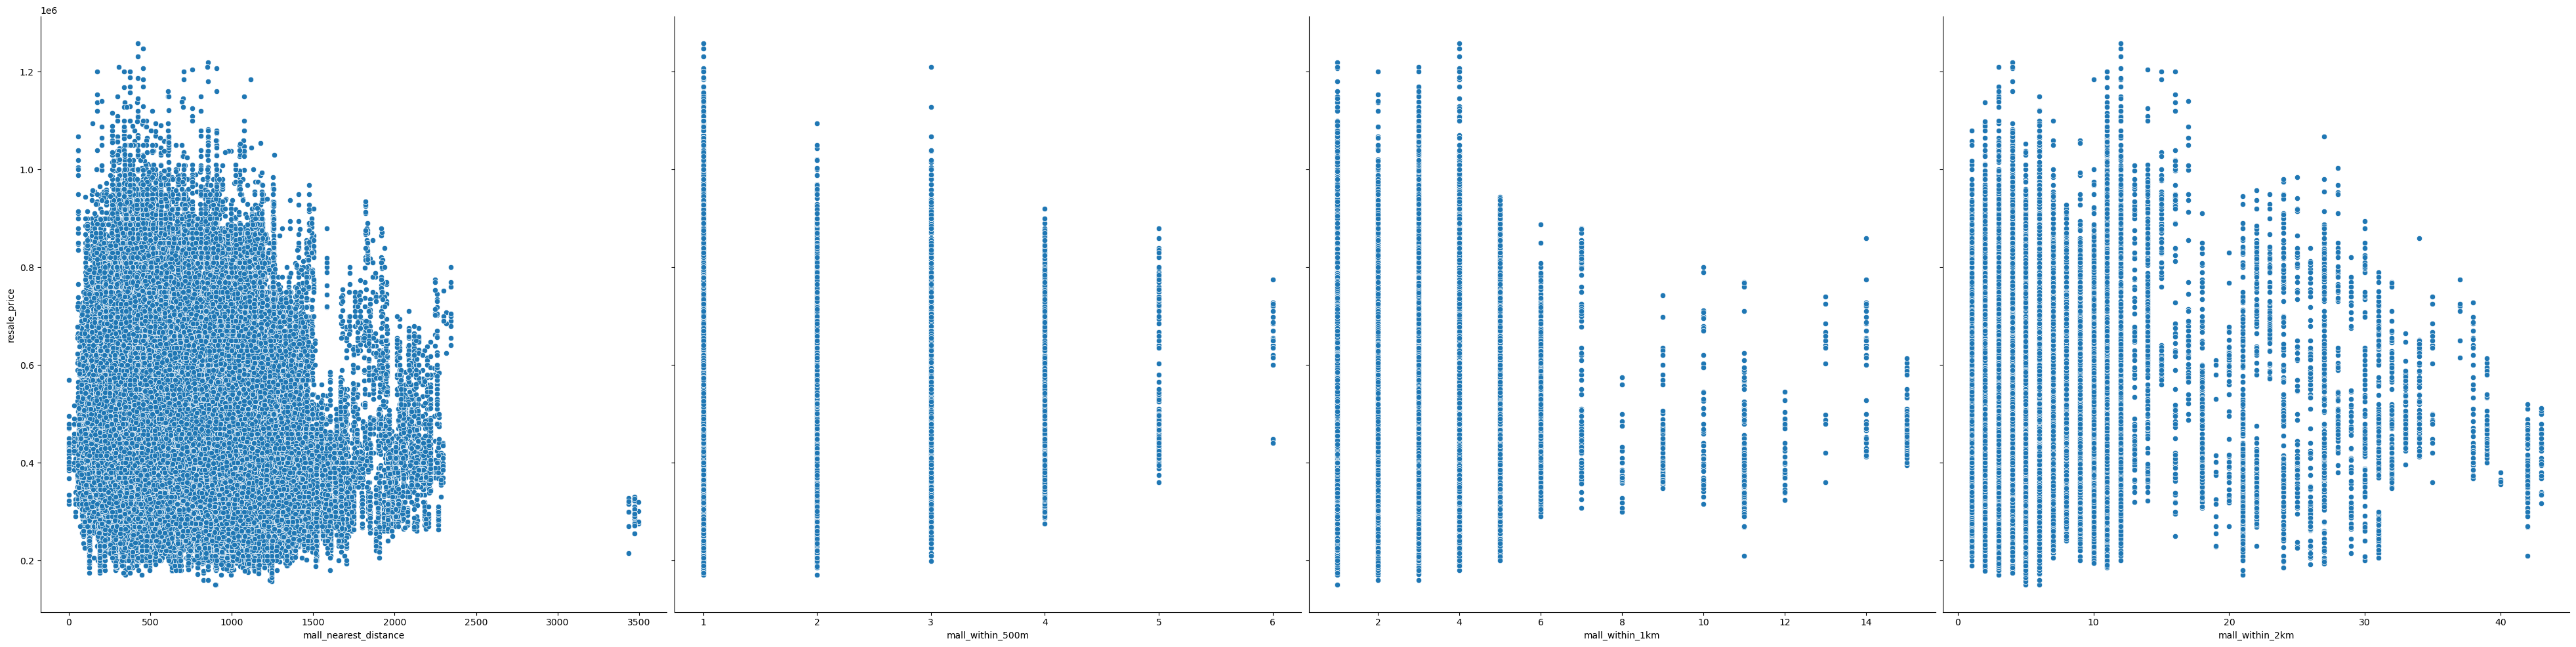

In [51]:
sns.pairplot(data=housing_df, x_vars=['mall_nearest_distance', 'mall_within_500m', 'mall_within_1km', 'mall_within_2km'], 
             y_vars='resale_price', height=10)

Observations:
- Generally negative correlation, and pattern looks consistent across all 3 categorical variables. 
- As such, to minimise the number of predictor variables, to use numeric variable `Mall_Nearest_Distance`

Hawker amenity

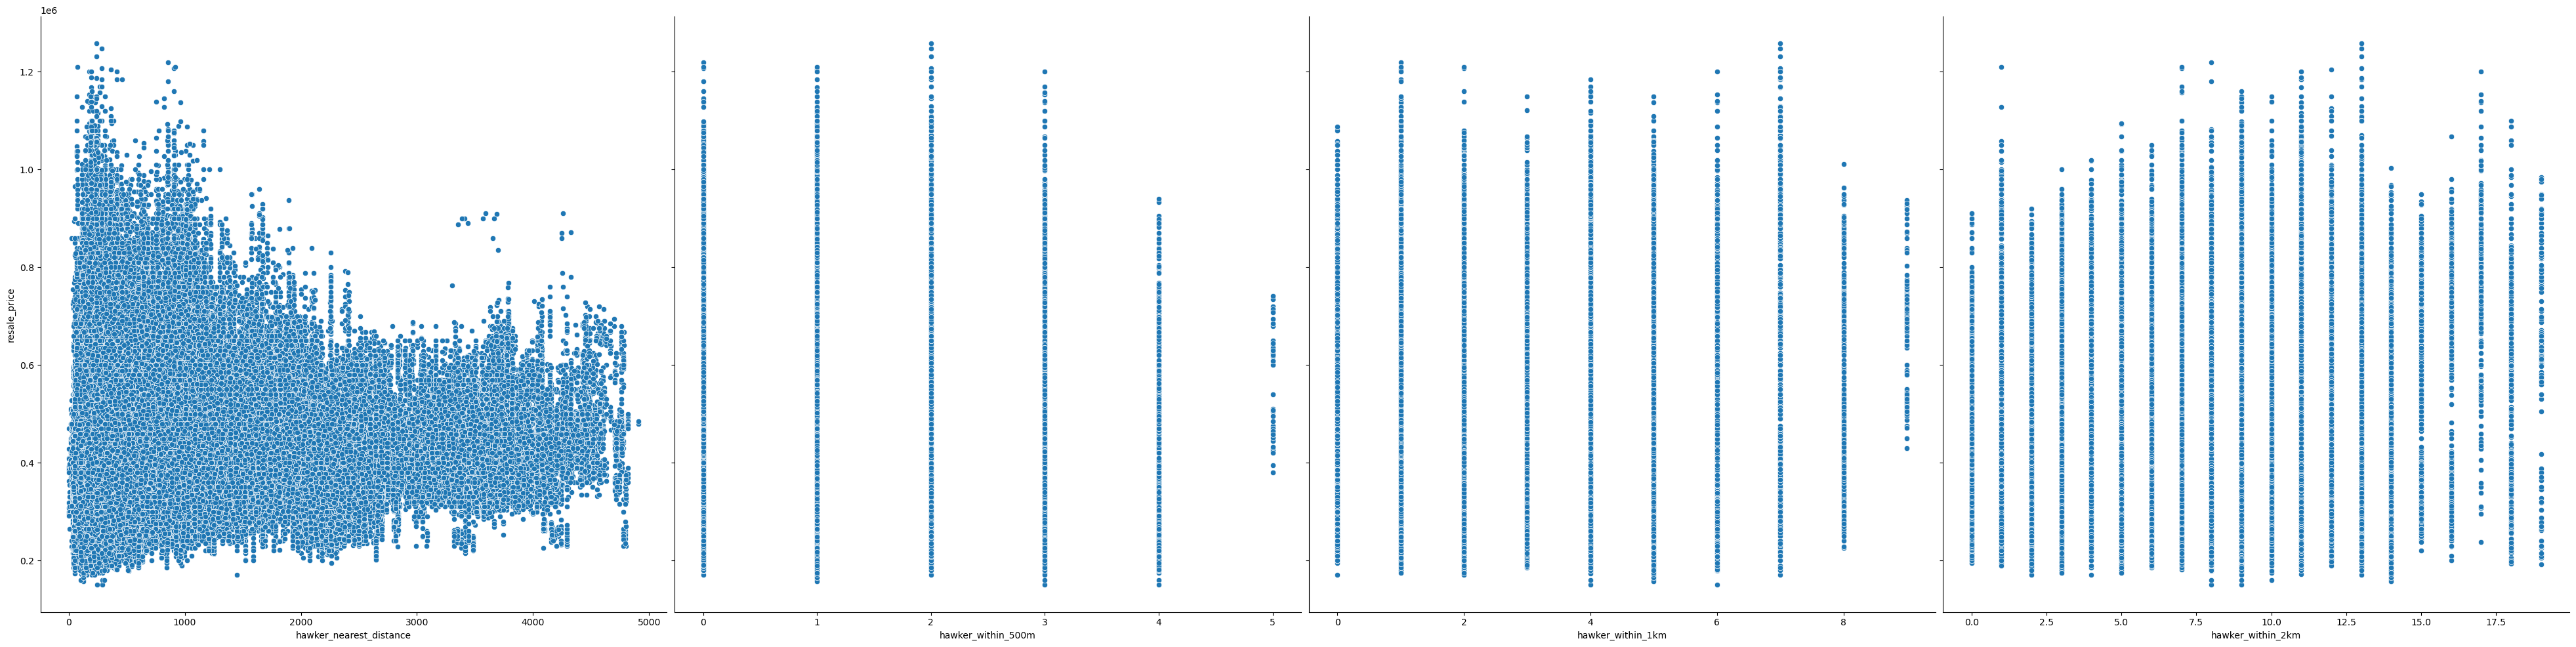

In [52]:
sns.pairplot(data=housing_df, x_vars=['hawker_nearest_distance', 'hawker_within_500m', 'hawker_within_1km', 'hawker_within_2km'], 
             y_vars='resale_price', height=10)

Observations:
- General negative correlation that is linear. Flattens out after 2km.
- Consider interaction term between `Hawker_Nearest_Distance` and `Hawker_Within_2km` to factor in this behaviour (i.e. beyond 2km, the effect of the interaction term becomes 0).

MRT amenity

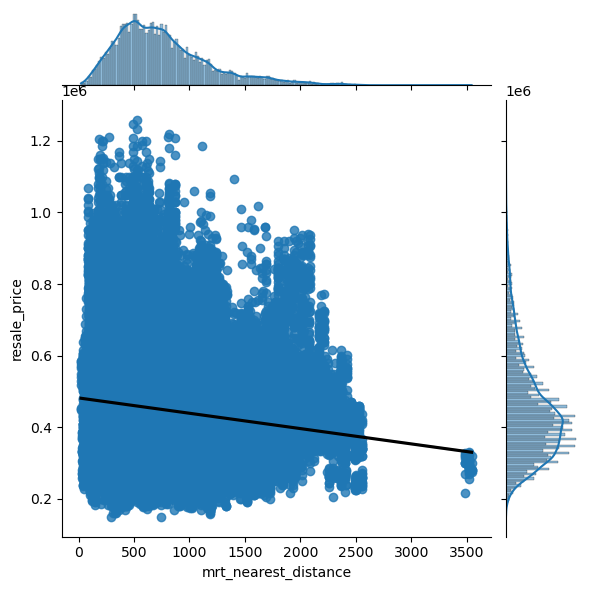

In [53]:
mrt = sns.jointplot(data=housing_df, x='mrt_nearest_distance', y='resale_price', kind='reg', joint_kws={'line_kws':{'color':'black'}})

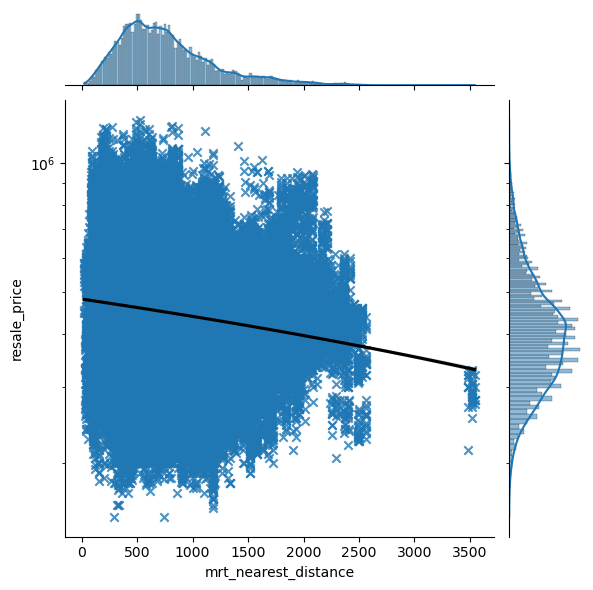

In [54]:
#As resale price has a skewed distributon, could consider taking the log of resale price for more normal distribution and better linear behaviour with predictor variable

mrt = sns.jointplot(data=housing_df, x='mrt_nearest_distance', y='resale_price', marker='x', kind='reg', joint_kws={'line_kws':{'color':'black'}})

#mrt.ax_joint.set_xscale('log')
mrt.ax_joint.set_yscale('log')

Observations:
- General negative correlation, looks broadly linear
- No significant break or discontinuity for numeric variable except for Changi Village outliers as seen earlier.
- To use numeric variable `mrt_nearest_distance`

Bus amenity

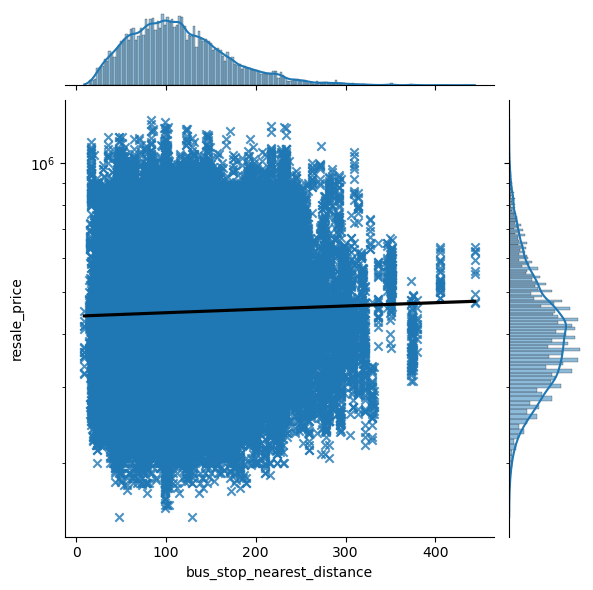

In [55]:
#As resale price has a skewed distributon, could consider taking the log of resale price for more normal distribution and better linear behaviour with predictor variable

bus = sns.jointplot(data=housing_df, x='bus_stop_nearest_distance', y='resale_price', marker='x', kind='reg', joint_kws={'line_kws':{'color':'black'}})

bus.ax_joint.set_yscale('log')

Observations:
- Little correlation between resale price and bus stop nearest distance, in line with the analysis on correlation coefficient above.

Schools

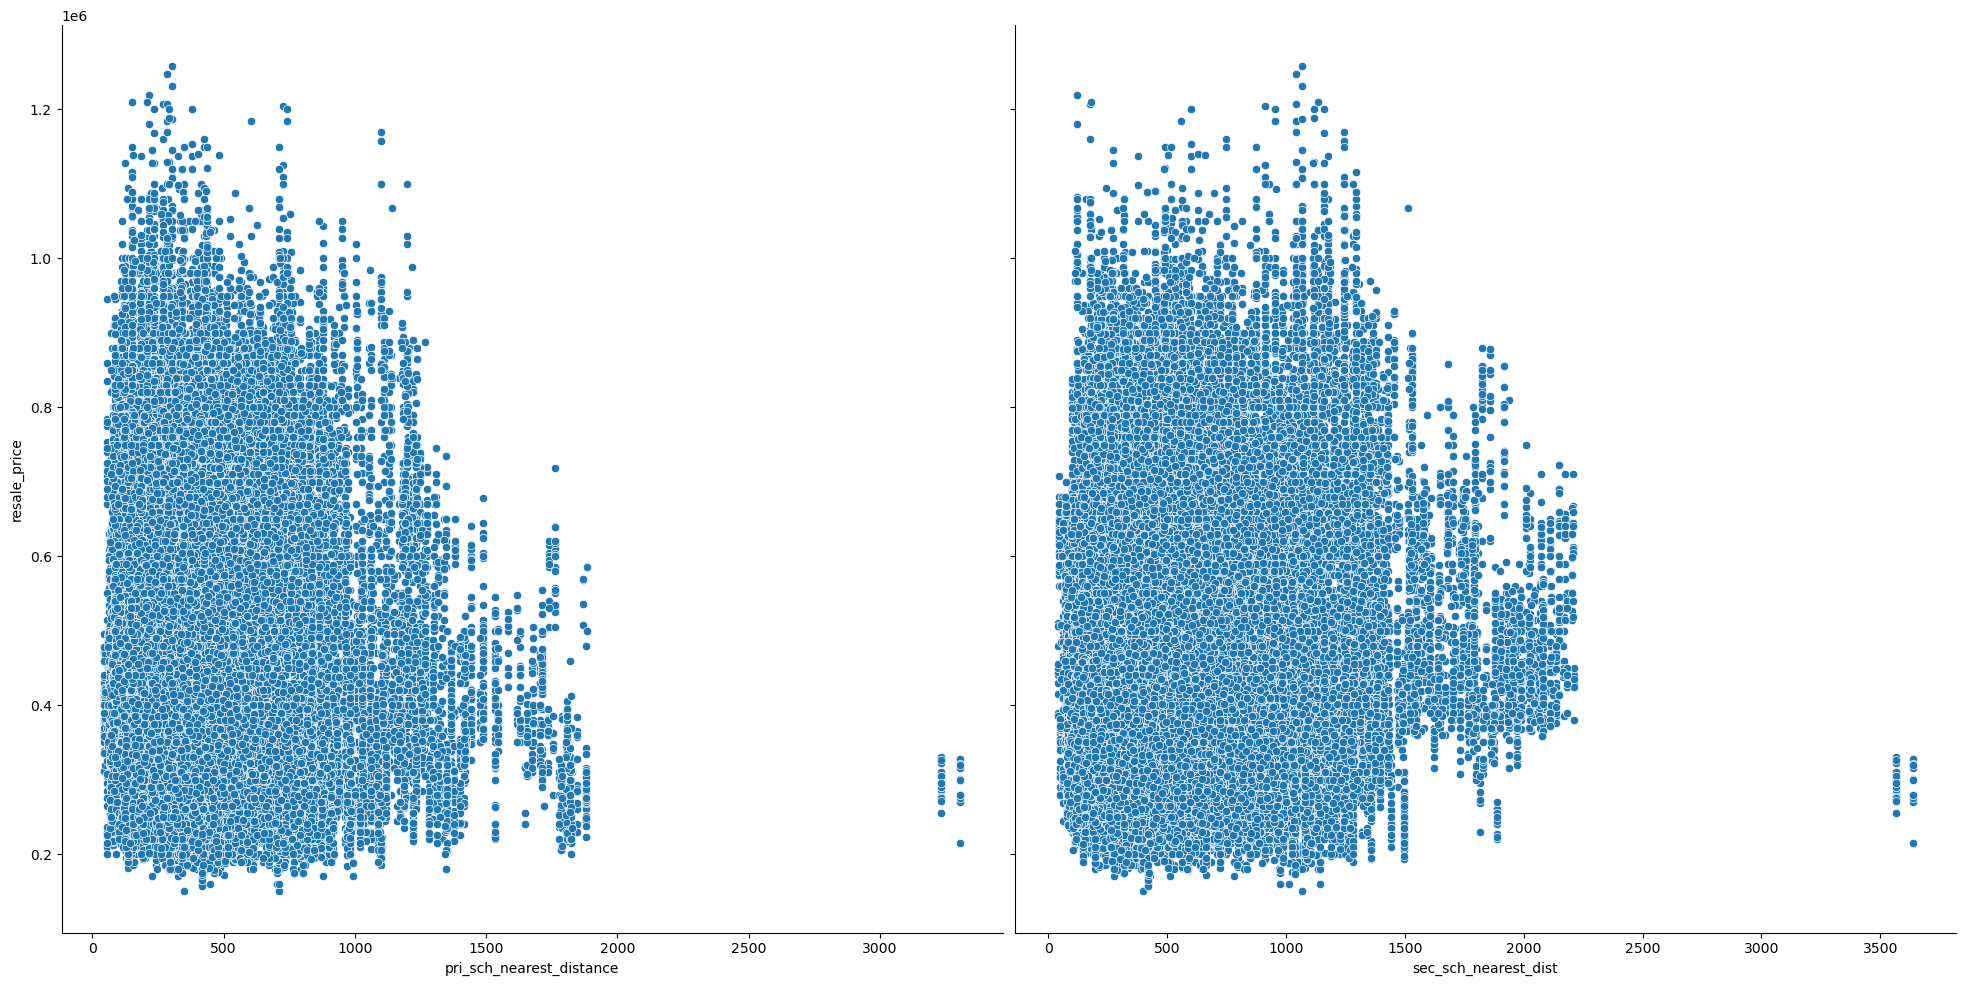

In [56]:
sns.pairplot(data=housing_df, x_vars=['pri_sch_nearest_distance', 'sec_sch_nearest_dist'], 
             y_vars='resale_price', height=10)

Observations:
- Similar to what is found in [literature](https://dollarsandsense.sg/hdb-property-prices-near-popular-primary-schools-really-cost/), there is no obvious price difference for HDB flats located within close proximity of the schools.  Will not include this attribute.

## Feature Engineering

We select the variables aforementioned in the EDA, and perform the necessary transformations. This includes:

1. Dummify categorical variables
2. Impute missing values for mall variables
3. Add interaction term between `hawker_nearest_distance` and `hawker_within_2km`
4. Add interaction term between `mrt_nearest_distance`, `mrt_interchange` and `bus_interchange`

To avoid overfitting, we will:

1. Gradually build up the model and see if addition of variables have any improvement to target RMSE
2. Add in regularisation as a last step to control overfitting

The models will be built with pipelines to enable modular adjustments to the models. The general schema of the model is as follows:
1. [All models A, B and C] take log of y for more normal distribution
2. [All models A, B and C] One-Hot Encoding to dummify categorical variables
3. [Model B with amenities] Impute missing values for `mall_nearest_distance`
4. [Model C with amenities and interaction] Generate polynomial features for `hawker` and `mrt` variables


In [57]:
# Create outcome variable y which will be the same for all models
y = housing_df['resale_price']

In [58]:
# Full model variables to be extracted from clean dataset that will be used by the different models accordingly
cat_var_list = [
                'planning_area', 
                'full_flat_type'
               ]
num_var_list = [
                'hdb_age', 'mid', 'floor_area_sqft',
                'tranc_year', 'tranc_month',
                'hawker_nearest_distance', 'hawker_within_2km',
                'mrt_nearest_distance', 'bus_interchange', 'mrt_interchange',
                'mall_nearest_distance'
               ]

X = housing_df[cat_var_list + num_var_list]

#### Y Log Resale Price for more normal distribution

In [59]:
# create transformer for y, resale price
lr_log = TransformedTargetRegressor(regressor=LinearRegression(),
                                    func=np.log, # define transform
                                    inverse_func=np.exp) # define inverse transform to get back y_pred

#### A. Simple model without amenities

In [60]:
# create an identity transformer object to return the input data unchanged, to be applied to numeric variables subsequently.
identity_transformer = FunctionTransformer(lambda x: x, feature_names_out='one-to-one')

In [61]:
# create one-hot encoder object
cat_transformer = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

In [62]:
# define simple model variables
cat_var_list_A = [
                'planning_area', 
                'full_flat_type'
]
num_var_list_A = [
                'hdb_age', 'mid', 'floor_area_sqft',
                'tranc_year', 'tranc_month', # we add in year and month variables to control for seasonality
]

In [63]:
# simple model
# PIPE: entire preprocessor pipeline, generates only the transformed X needed for simple model and drops all others that are not explicitly specified.

preprocessor_A = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_var_list_A),
        ('dummy', identity_transformer, num_var_list_A)
    ],
    remainder='drop', verbose_feature_names_out=False
)

#### B. Model with amenities

In [64]:
# create imputer for mall_nearest_distance
imp_transformer = KNNImputer()

In [65]:
# full model without interaction terms
# PIPE: entire preprocessor pipeline, generates only the transformed X needed for simple model
cat_var_list_B = [
                'planning_area', 
                'full_flat_type'
]

num_var_list_B = num_var_list.copy()
num_var_list_B.remove('mall_nearest_distance')

preprocessor_B = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_var_list_B),
        ('imp', imp_transformer, ['mall_nearest_distance']),
        ('dummy', identity_transformer, num_var_list_B) # identity transform all variables except last one which is the mall_nearest_distance
    ],
    remainder='drop', verbose_feature_names_out=False
)

#### C. Model with amenities and interaction

In [66]:
# create polynomial features transfomrer for interactive terms
poly_hawk_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_mrt_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [67]:
# full model with interaction terms
# PIPE: entire preprocessor pipeline, generates only the transformed X needed for simple model
cat_var_list_C = [
                'planning_area', 
                'full_flat_type'
]

num_var_list_C = [variable for variable in num_var_list if variable not in ['mall_nearest_distance',
                                                                           'hawker_nearest_distance',
                                                                           'hawker_within_2km',
                                                                           'mrt_nearest_distance',
                                                                           'mrt_interchange',
                                                                           'bus_interchange']
                 ]

preprocessor_C = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_var_list_C),
        ('imp', imp_transformer, ['mall_nearest_distance']),
        ('poly_hawk', poly_hawk_transformer, ['hawker_nearest_distance', 'hawker_within_2km']),
        ('poly_mrt', poly_mrt_transformer, ['mrt_nearest_distance', 'mrt_interchange', 'bus_interchange']),
        ('dummy', identity_transformer, num_var_list_C) # identity transform all variables except for the last 6 that have passed through interaction transformer
    ],
    remainder='drop', verbose_feature_names_out=False
)

## Data and Preprocessor Export
Export the preprocessors in preparation for model evaluation (including regularisation in the next step)

In [68]:
# export data
X.to_csv('../datasets/X.csv')  #full model variables to be extracted from clean dataset that will be used by the different models accordingly
y.to_csv('../datasets/y.csv')  #outcome variable dataset

In [69]:
# define folder path for saved models
folder_path = '../models/'

In [70]:
# saving preprocessors
dill.dump(preprocessor_A, open(folder_path + 'preprocessor_A.sav', 'wb'))
dill.dump(preprocessor_B, open(folder_path + 'preprocessor_B.sav', 'wb'))
dill.dump(preprocessor_C, open(folder_path + 'preprocessor_C.sav', 'wb'))

In [71]:
# saving regression transformer
dill.dump(lr_log, open(folder_path + 'lr_log.sav', 'wb'))